In [1]:
##### setting up the environment
from datetime import date, datetime, timedelta
import os
from typing import Literal
import time
import re
import pandas as pd
import numpy as np
import json
import requests
from dotenv import load_dotenv
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima 
import seaborn as sns
from tabulate import tabulate
import math
import warnings

# Set up the data

In [2]:
BUCKET = '/mnt/dsa/home/gpchow/inflationpers/dataframe/'

# headline inflation (monthly frequency)
headline_inflation_df = pd.read_parquet(BUCKET + "inflation-headline.parquet")

# core inflation (quarterly frequency)
core_inflation_df = pd.read_parquet(BUCKET + './inflation-core.parquet')

# inflation by component (monthly frequency)
inflation_component_month_cont = pd.read_parquet(BUCKET + "inflation-component.parquet")


# Headline inflation persistence
## Analysis using Full Sample

In [3]:
# estimate using ols
## included up to 12 lags for monthly data
num_lags = 12

# Create the lagged variable DataFrame
X = pd.DataFrame(index=headline_inflation_df.index)

for lag in range(1, num_lags + 1):
    X[f'cpi_month_lag{lag}'] = headline_inflation_df['cpi_month'].shift(lag)

# Add constant term to X
X = sm.add_constant(X)

### 1970 - 2023

In [4]:
start_date = pd.to_datetime('1972-01-01')

headline_inflation_df_full = headline_inflation_df.loc[start_date:,]
X_full = X.loc[start_date:,]

model = sm.OLS(headline_inflation_df_full['cpi_month'], X_full)
results = model.fit()
rho = sum(results.params[1:])
print(rho)

0.9509693664653314


### 1991 - 2023

In [5]:
start_date_90 = pd.to_datetime('1991-01-01')

headline_inflation_df_full_90 = headline_inflation_df.loc[start_date_90:,]
X_full_90 = X.loc[start_date_90:,]

model_90 = sm.OLS(headline_inflation_df_full_90['cpi_month'], X_full_90)
results_90 = model_90.fit()
rho_90 = sum(results_90.params[1:])
print(rho_90)

0.9086233782734745


## Rolling estimate (window size of 14 years / 168 months)

In [6]:
window_size = 168

rolling_rho = pd.DataFrame(index=headline_inflation_df_full.index[window_size:])
rolling_rho['rho'] = np.nan

for i in range(window_size, len(headline_inflation_df_full)):
    train_subset = headline_inflation_df_full[i-window_size:i]
    X_lagged = X_full[i-window_size:i]
    date = headline_inflation_df_full.index[i]

    # Fit the OLS model
    model = sm.OLS(train_subset['cpi_month'], X_lagged)
    results = model.fit()
    rolling_rho.loc[date]['rho'] = results.params[1:].sum(axis=0)
    del model

### mean of rolling estimate of different period of time

In [7]:
# until 2008 (pre-GFC)
rolling_rho[:'2008-12-01'].mean()

rho    0.941563
dtype: float64

In [8]:
# 2009 - Feb-2020 (post-GFC, but pre-COVID-19)
rolling_rho['2009-01-01':'2020-02-01'].mean()

rho    0.837391
dtype: float64

In [9]:
# March-2020 (after COVID-19 strikes)
rolling_rho['2020-03-01':].mean()

rho    0.853701
dtype: float64

### rolling mean of inflation 

In [10]:
rolling_mean = headline_inflation_df_full['cpi_month'].rolling(window=window_size).mean()
rolling_mean = rolling_mean.dropna()
rolling_mean = rolling_mean[1:]
rolling_mean.name = 'mean'

rolling_rho_merge = pd.merge(rolling_mean, rolling_rho, left_index = True, right_index = True)

### graph

In [11]:
# define the crisis periods
crisis_dates = pd.to_datetime(['1997-12-01',
                               '1998-03-01',
                               '2007-03-01', '2007-06-01', '2007-09-01', '2007-12-01',
                               '2008-03-01', '2008-06-01', '2008-09-01', '2008-12-01',
                               '2020-06-01', '2020-09-01', '2020-12-01', 
                               '2021-03-01', '2021-06-01', '2021-09-01'])

crisis_periods = [((date - pd.DateOffset(months=3)).strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')) for date in crisis_dates]


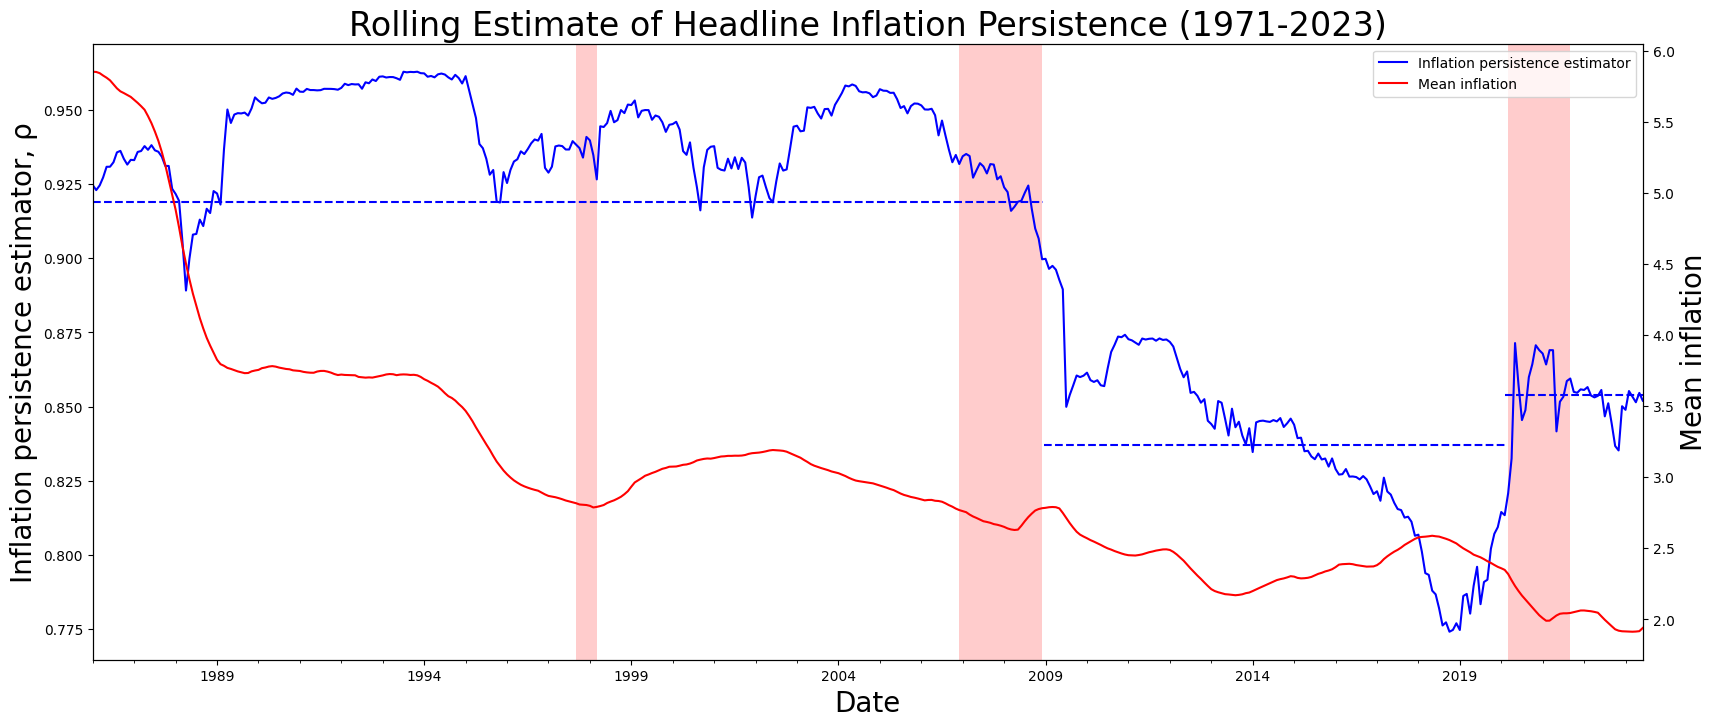

In [12]:
plt.figure(figsize=(20, 8))
ax1 = plt.gca()  

# Plot the rolling estimate of rho on the first y-axis
rolling_rho_merge['rho'].plot(kind='line', ax=ax1, color='blue', label='Inflation persistence estimator')
ax1.set_xlabel("Date", fontsize=20)
ax1.set_ylabel("Inflation persistence estimator, ρ", fontsize=20)

ax1.axhline(y=0.919, color='blue', linestyle='--', xmin=0, xmax=0.613)
ax1.axhline(y=0.837, color='blue', linestyle='--', xmin=0.614, xmax=0.911)
ax1.axhline(y=0.854, color='blue', linestyle='--', xmin=0.911, xmax=1)

# Create a twin axes for the second y-axis
ax2 = ax1.twinx()

# Plot the rolling mean of inflation on the second y-axis
rolling_rho_merge['mean'].plot(kind='line', ax=ax2, color='red', label='Mean inflation')
ax2.set_ylabel("Mean inflation", fontsize=20)

for start_date, end_date in crisis_periods:
    ax1.axvspan(start_date, end_date, facecolor='red', alpha=0.2) # highlight the crisis periods

# Combine the legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Rolling Estimate of Headline Inflation Persistence (1971-2023)', fontsize=24)
plt.show()

### correlation between rolling mean and persistence of inflation

In [13]:
rolling_rho_merge['mean'].corr(rolling_rho_merge['rho'])

0.5774513165773086

In [14]:
rolling_rho_merge['mean']

date
1986-01-01    5.851347
1986-02-01    5.849697
1986-03-01    5.841287
1986-04-01    5.824361
1986-05-01    5.809150
                ...   
2023-02-01    1.914438
2023-03-01    1.913423
2023-04-01    1.914618
2023-05-01    1.917239
2023-06-01    1.939631
Name: mean, Length: 450, dtype: float64

# Core inflation persistence
## Analysis using Full Sample

In [15]:
num_lags1 = 4

# Create the lagged variable DataFrame
X1 = pd.DataFrame(index=core_inflation_df.index)

for lag in range(1, num_lags1 + 1):
    X1[f'cpi_core_quarter_lag{lag}'] = core_inflation_df['cpi_core_quarter'].shift(lag)

# Add constant term to X
X1 = sm.add_constant(X1)

In [16]:
start_date1 = pd.to_datetime('1993-06-30')

core_inflation_df_full = core_inflation_df.loc[start_date1:,]
X1_full = X1.loc[start_date1:,]

model1 = sm.OLS(core_inflation_df_full['cpi_core_quarter'], X1_full)
results1 = model1.fit()
rho1 = sum(results1.params[1:])
print(rho1)

0.8800321680933126


## Rolling estimate (window size of 4 years/ 56 quarters)

In [17]:
window_size1 = 56

rolling_rho1 = pd.DataFrame(index=core_inflation_df.index[window_size1:])
rolling_rho1['rho'] = np.nan

for i in range(window_size1, len(core_inflation_df_full)):
    train_subset = core_inflation_df_full[i-window_size1:i]
    X1_full_lagged = X1_full[i-window_size1:i]
    date = core_inflation_df_full.index[i]

    # Fit the OLS model
    model = sm.OLS(train_subset['cpi_core_quarter'], X1_full_lagged)
    results = model.fit()
    rolling_rho1.loc[date]['rho'] = results.params[1:].sum(axis=0)
    del model

### mean of rolling estimate of different period of time

In [18]:
# until 2008 (pre-GFC)
rolling_rho1[:'2008-12-31'].mean()

rho    0.909317
dtype: float64

In [19]:
# 2009 - Feb-2020 (post-GFC, but pre-COVID-19)
rolling_rho1['2009-01-01':'2019-12-31'].mean()

rho    0.834923
dtype: float64

In [20]:
# March-2020 (after COVID-19 strikes)
rolling_rho1['2020-01-01':].mean()

rho    0.776413
dtype: float64

### rolling mean of inflation 

In [21]:
rolling_mean1 = core_inflation_df_full['cpi_core_quarter'].rolling(window=window_size1).mean()
rolling_mean1 = rolling_mean1.dropna()
rolling_mean1 = rolling_mean1[1:]
rolling_mean1.name = 'mean'

rolling_rho1_merge = pd.merge(rolling_mean1, rolling_rho1, left_index = True, right_index = True)

### graph

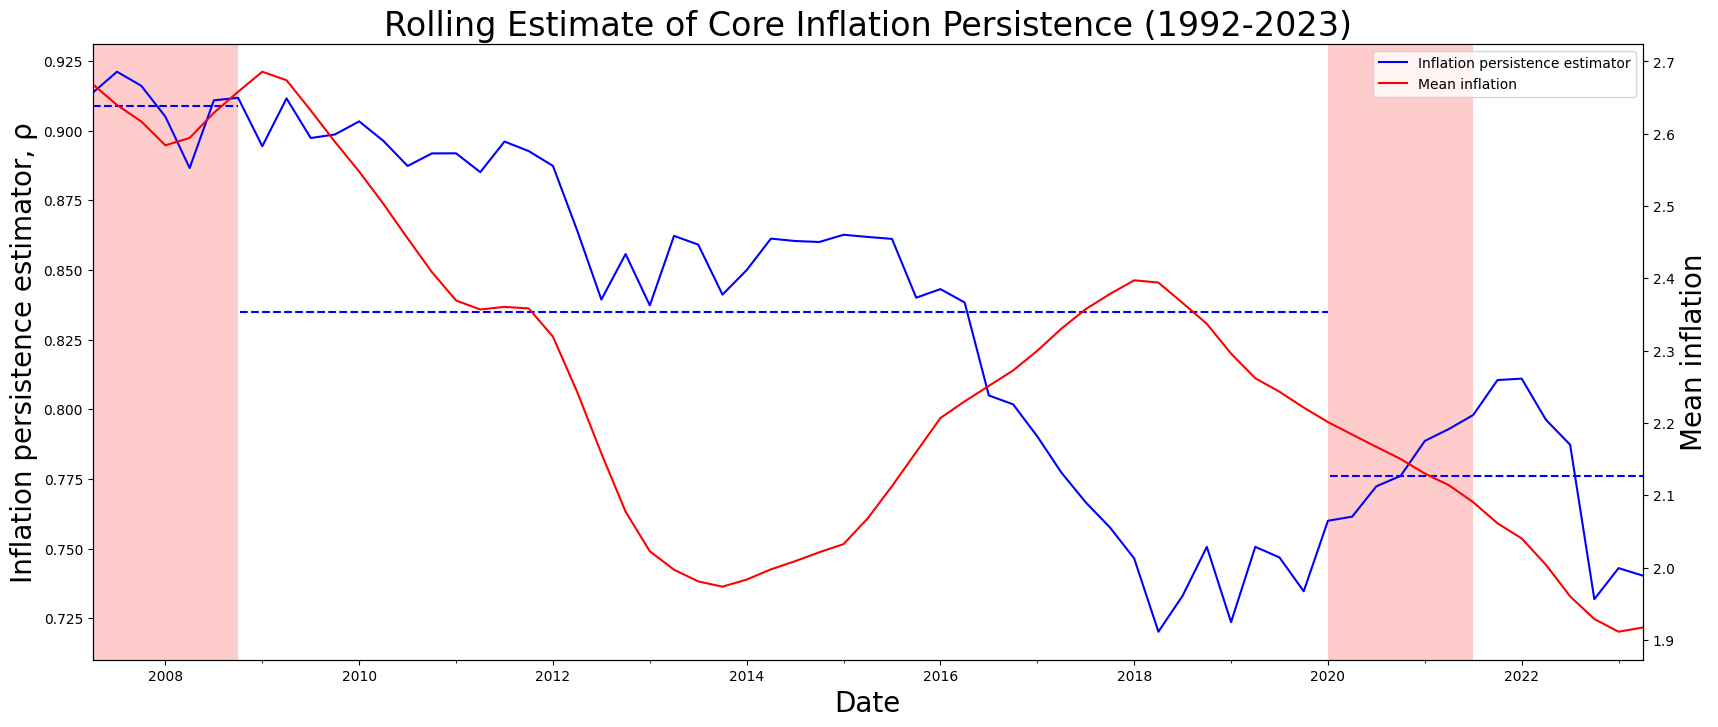

In [22]:
plt.figure(figsize=(20, 8))
ax1 = plt.gca()  

# Plot the rolling estimate of rho on the first y-axis
rolling_rho1_merge['rho'].plot(kind='line', ax=ax1, color='blue', label='Inflation persistence estimator')
ax1.set_xlabel("Date", fontsize=20)
ax1.set_ylabel("Inflation persistence estimator, ρ", fontsize=20)

ax1.axhline(y=0.909, color='blue', linestyle='--', xmin=0, xmax=0.094)
ax1.axhline(y=0.835, color='blue', linestyle='--', xmin=0.095, xmax=0.797)
ax1.axhline(y=0.776, color='blue', linestyle='--', xmin=0.798, xmax=1)

# Create a twin axes for the second y-axis
ax2 = ax1.twinx()

# Plot the rolling mean of inflation on the second y-axis
rolling_rho1_merge['mean'].plot(kind='line', ax=ax2, color='red', label='Mean inflation')
ax2.set_ylabel("Mean inflation", fontsize=20)

for start_date, end_date in crisis_periods:
    ax1.axvspan(start_date, end_date, facecolor='red', alpha=0.2) # highlight the crisis periods

# Combine the legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Rolling Estimate of Core Inflation Persistence (1992-2023)', fontsize=24)
plt.show()

### correlation between rolling mean and persistence of inflation

In [23]:
rolling_rho1_merge['mean'].corr(rolling_rho1_merge['rho'])

0.47155913238730074

# Inflation persistence by component
## Analysis using Full Sample

In [24]:
component_df = pd.DataFrame()

component_df['component'] = None
component_df['coefficient'] = None

def modeling(df, component, num_lags, output_choice):
    # create the lagged variable dataframe
    X = pd.DataFrame(index=df[component].dropna().index)

    for lag in range(1, num_lags + 1):
        X[f'{component}_lag{lag}'] = df[component].shift(lag)

    # Add constant term to X
    X = sm.add_constant(X)

    start_date_full = df[component].dropna().index[num_lags]

    inflation_component_month_cont_full = df[component].loc[start_date_full:,]
    X_full = X.loc[start_date_full:,]

    # Fit the OLS model
    model = sm.OLS(inflation_component_month_cont_full, X_full)
    results = model.fit()

    coef = sum(results.params[1:])

    if output_choice == 1:
        print(component, ": ", coef)
    elif output_choice == 2:
        component_df = pd.DataFrame({'component': [component], 'coefficient': [coef]})
        return component_df
    else:
        print("Invalid output choice. Please enter 1 to print the result or 2 to store it in a DataFrame.")

for component in inflation_component_month_cont.columns:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result_df_1 = modeling(inflation_component_month_cont, component, 12, 2)
    component_df = pd.concat([component_df, result_df_1], ignore_index=True)

component_df['component'] = component_df['component'].str.rstrip('_yoy')
component_df = component_df.sort_values(by='coefficient', ascending=False)
component_df['coefficient'] = component_df['coefficient'].apply(lambda x: math.ceil(x * 1000) / 1000)
component_df

,component,coefficient
2,communication,0.958
7,healthcare,0.951
12,restaurant,0.948
5,food_away_from_home,0.946
14,non-alcoholic_beverages,0.933
11,accommodation,0.923
3,education,0.911
8,utilities,0.909
6,home_essential,0.904
4,food_at_home,0.904


## Rolling estimate (window size of 4 years / 168 months)

In [25]:
rho_component = pd.DataFrame(columns=inflation_component_month_cont.columns)

def modeling_rolling_component(df, component, num_lags, window_size, rho_full):
    # create the lagged variable dataframe
    X = pd.DataFrame(index=df[component].dropna().index)

    for lag in range(1, num_lags + 1):
        X[f'{component}_lag{lag}'] = df[component].shift(lag)

    # Add constant term to X
    X = sm.add_constant(X)

    start_date_full = df[component].dropna().index[num_lags]

    inflation_component_month_cont_full = df[component].loc[start_date_full:,]
    X_full = X.loc[start_date_full:,]
    
    models_coefficients = pd.DataFrame()  

    for i in range(window_size, len(inflation_component_month_cont_full)):
        train_subset = inflation_component_month_cont_full[i-window_size:i]
        X_lagged = X_full[i-window_size:i]

        # Fit the OLS model
        model = sm.OLS(train_subset, X_lagged)
        results = model.fit()
        models_coefficients[f"Model {i+1}"] = results.params
    
    del model 
    
    rho = models_coefficients[1:].sum(axis=0)
    rho.index = pd.DatetimeIndex(inflation_component_month_cont_full.index[window_size:])

    rho_full[component] = rho
    return rho_full

for component in inflation_component_month_cont.columns:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        modeling_rolling_component(inflation_component_month_cont, component, 12, 168, rho_component)

### mean of rolling estimate of different period

In [26]:
component_before_mean = rho_component[:'2008-12-31'].mean().round(3)
component_before_mean.name = 'mean before 2009'
component_before_mean = pd.DataFrame(component_before_mean)

component_between_mean = rho_component['2009-01-01':'2020-02-01'].mean().round(3)
component_between_mean.name = 'mean 2009 to 2020'
component_between_mean = pd.DataFrame(component_between_mean)

component_after_mean = rho_component['2020-03-01':].mean().round(3)
component_after_mean.name = 'mean 2020 and after'
component_after_mean = pd.DataFrame(component_after_mean)

component_mean_4 = pd.merge(component_before_mean, component_between_mean, left_index = True, right_index = True)
component_mean_4 = pd.merge(component_mean_4, component_after_mean, left_index=True, right_index=True)
component_mean_4.reset_index(inplace = True)
component_mean_4.rename(columns = {'name': 'component'}, inplace = True)
component_mean_4['component'] = component_mean_4['component'].str.rstrip('_yoy')

del component_before_mean, component_after_mean
component_mean_4

,component,mean before 2009,mean 2009 to 2020,mean 2020 and after
0,alcoholic_beverages,0.822,0.792,0.877
1,clothing_footwear,0.887,0.851,0.813
2,communication,0.940,0.906,0.711
3,education,0.909,0.952,0.941
4,food_at_home,0.919,0.912,0.910
5,food_away_from_home,0.964,0.947,0.921
6,home_essential,0.922,0.918,0.823
7,healthcare,0.956,0.913,0.937
8,utilities,0.965,0.917,0.856
9,miscellaneous_goods,0.895,0.875,0.867


In [28]:
component_mean_4.to_csv("mean_inflation.csv")

### graph

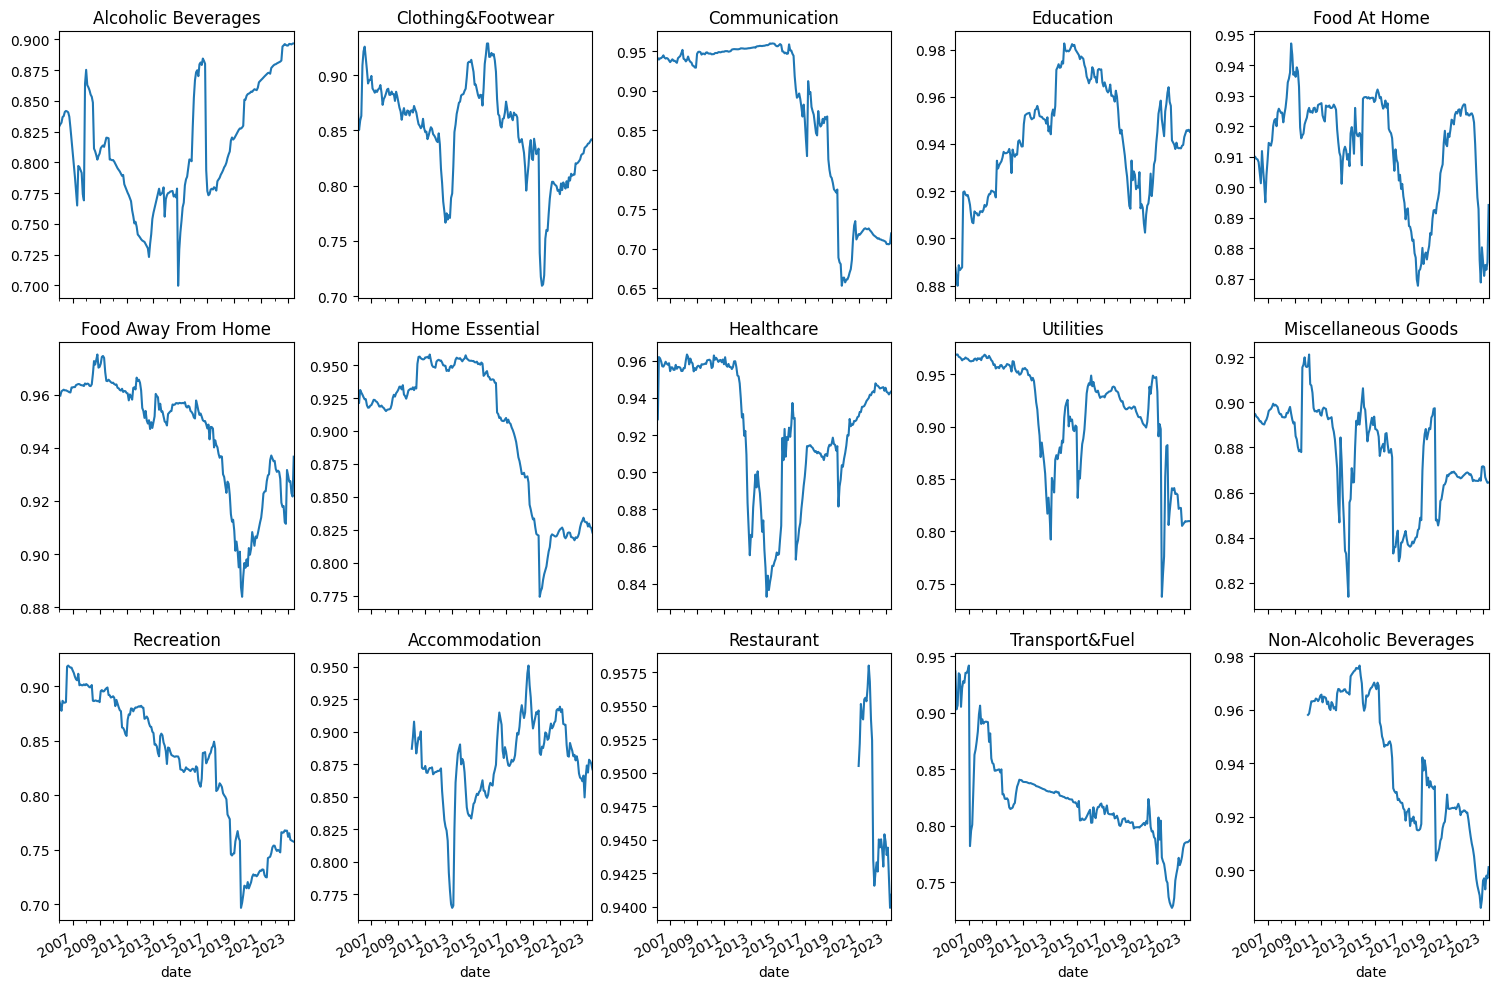

In [27]:
import matplotlib.ticker as ticker
from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

num_columns = len(rho_component.columns)
num_subplots = min(5 * 3, num_columns)  # Ensure the number of subplots doesn't exceed the number of columns

# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

# Flatten the axes array to easily loop through each subplot
axes = axes.flatten()

# Loop through each subplot
for i, ax in enumerate(axes):
    if i < num_subplots:
        col_name = rho_component.columns[i]
        rho_component[col_name].plot(ax=ax)
        ax.set_title(col_name.rstrip('_yoy').replace("_", " ").title())

        if col_name == "clothing_footwear_yoy":
            ax.set_title("Clothing&Footwear")
        elif col_name == "transport_fuel_yoy":
            ax.set_title("Transport&Fuel")
        fig.autofmt_xdate()
       
    else:
        # If there are more subplots than columns, remove the empty subplot
        fig.delaxes(ax)

plt.tight_layout()
plt.show()